In [1]:
import pandas as pd
import pickle
import statsmodels.formula.api as smf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
with open("pickles/emd_deltas_pd.pickle", "rb") as pickleFile:
    description, emd_deltas_pd = pickle.load(pickleFile)
    print(description)
    print(emd_deltas_pd)
    
with open("pickles/subgraph_features_pd.pickle", "rb") as pickleFile:
    description, subgraph_features_pd = pickle.load(pickleFile)
    print(description)
    print(subgraph_features_pd)

EMD between DCPD before and after removal    EMD Delta_k = EMD(k,1) - EMD(k-1, 1)
     Algorithm Name Dimension      Graph Name   K  EMD Delta Normalized
0               pca         2            wiki   2              0.000000
1               pca         2            wiki   3              0.000703
2               pca         2            wiki   4              0.000000
3               pca         2            wiki   5              0.003374
4               pca         2            wiki   6              0.008832
...             ...       ...             ...  ..                   ...
6020           sdne        20  BTER-arbitrary  47              0.072700
6021           sdne        20  BTER-arbitrary  48              0.349695
6022           sdne        20  BTER-arbitrary  49              0.395565
6023           sdne        20  BTER-arbitrary  50              0.252398
6024           sdne        20  BTER-arbitrary  51              0.097695

[6025 rows x 5 columns]
Dataframe in which each row i

In [3]:
#emd_deltas_pd = emd_deltas_pd[[False,True,True,True,False]]
emd_deltas_pd = emd_deltas_pd.set_index(["Graph Name", "K"])
emd_deltas_pd.columns = ["Algorithm", "Dimension", "EMD"]
emd_deltas_pd

Algorithm Dimension       EMD
Graph Name     K                               
wiki           2        pca         2  0.000000
               3        pca         2  0.000703
               4        pca         2  0.000000
               5        pca         2  0.003374
               6        pca         2  0.008832
...                     ...       ...       ...
BTER-arbitrary 47      sdne        20  0.072700
               48      sdne        20  0.349695
               49      sdne        20  0.395565
               50      sdne        20  0.252398
               51      sdne        20  0.097695

[6025 rows x 3 columns]

In [4]:
subgraph_features_pd = subgraph_features_pd.set_index(["Graph Name", "K"])
subgraph_features_pd.columns = ["EdgeDensity", "Size", "Clustering", "Transitivity"]
subgraph_features_pd

EdgeDensity      Size  Clustering  Transitivity
Graph Name     K                                                  
wiki           2      0.000000  0.000000    0.000000      0.000000
               3      0.000006 -0.000419   -0.000189      0.000009
               4      0.000000  0.000000    0.000000      0.000000
               5      0.000024 -0.001675   -0.000179      0.000043
               6      0.000048 -0.003349   -0.000366      0.000101
...                        ...       ...         ...           ...
BTER-arbitrary 47     0.115726 -0.011149    0.053588      0.058775
               48     0.000000  0.000000    0.000000      0.000000
               49     0.001729 -0.000210    0.001193      0.001209
               50     0.000000  0.000000    0.000000      0.000000
               51     0.003148 -0.000421    0.001905      0.002681

[355 rows x 4 columns]

In [7]:
np.min(subgraph_features_pd["Size"])

-0.4608718373034882

In [10]:
emd_features_pd = emd_deltas_pd.join(subgraph_features_pd, how="left").reset_index()

In [11]:
emd_features_pd.describe()

,K,EMD,EdgeDensity,Size,Clustering,Transitivity
count,6025.000000,6025.000000,6025.000000,6025.000000,6025.000000,6025.000000
mean,30.019585,0.174800,0.013364,-0.023893,0.006674,0.010485
std,28.161245,0.242273,0.043585,0.051420,0.026659,0.021976
min,2.000000,0.000000,0.000000,-0.460872,-0.071300,-0.015189
25%,9.000000,0.007783,0.000273,-0.025663,0.000000,0.000035
50%,20.000000,0.073949,0.002570,-0.005182,0.000799,0.003399
75%,41.000000,0.233854,0.009215,-0.000248,0.005393,0.011511
max,115.000000,1.000000,0.498701,0.000000,0.295521,0.228580


In [12]:
algs = ["pca", "lap", "HOPE", "n2v", "sdne", "hgcn"]
d_s = ["2", "10", "20"]
coefs = ["EdgeDensity", "Size", "Clustering", "Transitivity"]
reg_results_dict = {
    "Coefficient Name": np.array([]),
    "Embedding Dimension": np.array([]),
    "Embedding Algorithm": np.array([]),
    "Coefficient Value": np.array([]),
    "Coefficient Std. Error": np.array([])
}
for d_str in d_s:
    for alg in algs:
        print("Algorithm: {} d: {}".format(alg, d_str))
        correct_alg = emd_features_pd["Algorithm"] == alg
        correct_d = emd_features_pd["Dimension"] == d_str
        filtered_pd = emd_features_pd[correct_alg & correct_d]
        if len(filtered_pd) == 0:
            continue
            
        ols_model = smf.ols('EMD ~ EdgeDensity + Size + Clustering + Transitivity', data=filtered_pd)
        result = ols_model.fit()
        #print(result.summary())
        
        coef_names = result.params.index[1:].to_numpy()
        coef_values = result.params.loc[coef_names].to_numpy()
        coef_std_error = result.bse.loc[coef_names].to_numpy()
        
        reg_results_dict["Coefficient Name"] = np.append(reg_results_dict["Coefficient Name"], coef_names)
        reg_results_dict["Coefficient Value"] = np.append(reg_results_dict["Coefficient Value"], coef_values)
        reg_results_dict["Coefficient Std. Error"] = np.append(reg_results_dict["Coefficient Std. Error"], coef_std_error)
        reg_results_dict["Embedding Dimension"] = np.append(reg_results_dict["Embedding Dimension"], [d_str] * len(coef_names))
        reg_results_dict["Embedding Algorithm"] = np.append(reg_results_dict["Embedding Algorithm"], [alg] * len(coef_names))


Algorithm: pca d: 2
Algorithm: lap d: 2
Algorithm: HOPE d: 2
Algorithm: n2v d: 2
Algorithm: sdne d: 2
Algorithm: hgcn d: 2
Algorithm: pca d: 10
Algorithm: lap d: 10
Algorithm: HOPE d: 10
Algorithm: n2v d: 10
Algorithm: sdne d: 10
Algorithm: hgcn d: 10
Algorithm: pca d: 20
Algorithm: lap d: 20
Algorithm: HOPE d: 20
Algorithm: n2v d: 20
Algorithm: sdne d: 20
Algorithm: hgcn d: 20


In [13]:
reg_results_pd = pd.DataFrame(reg_results_dict)
reg_results_pd["Coefficient CI"] = 1.96 * reg_results_pd["Coefficient Std. Error"]

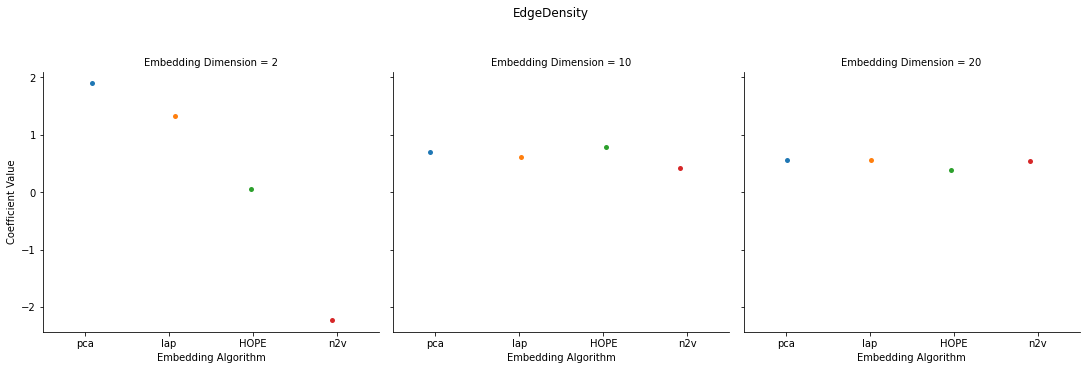

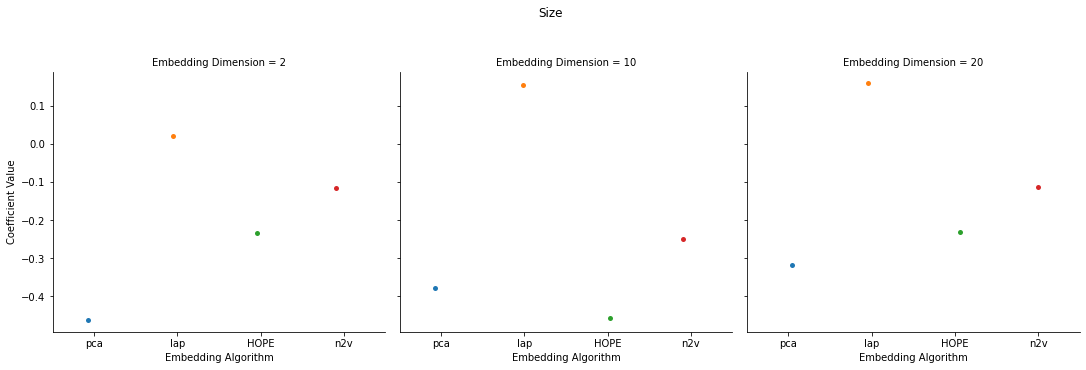

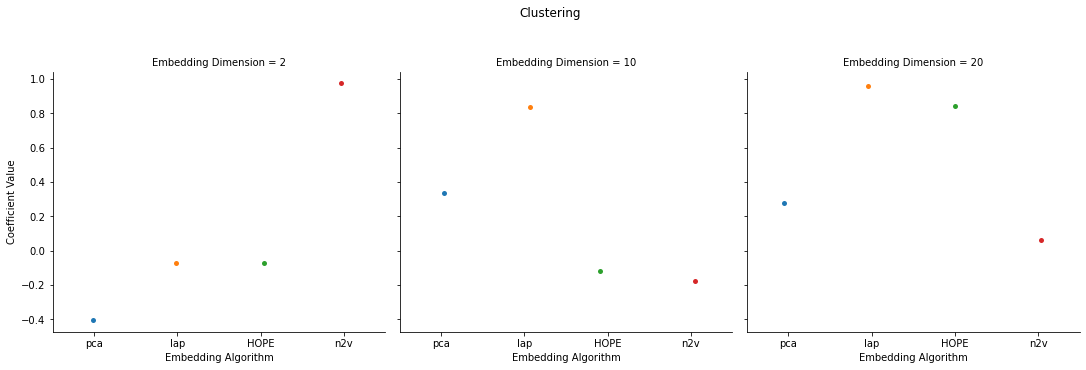

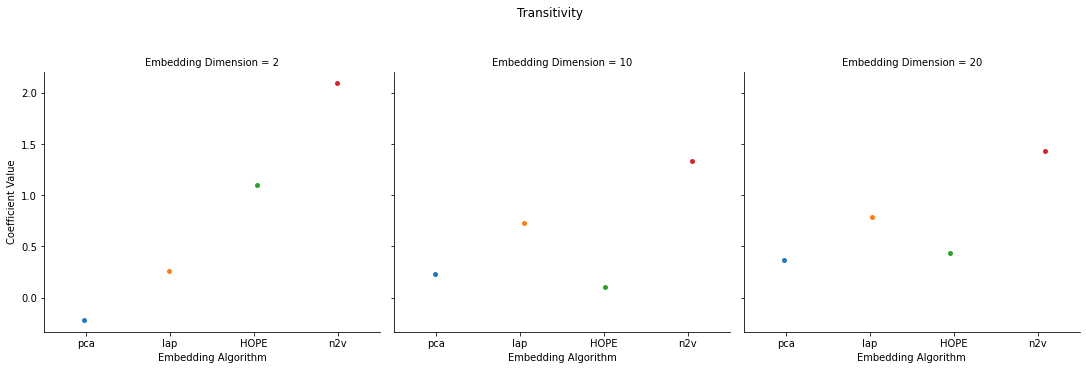

In [46]:
for coef_name in coefs:
    reg_results_subset = reg_results_pd[reg_results_pd["Coefficient Name"] == coef_name]
    g = sns.catplot(x="Embedding Algorithm",
                y="Coefficient Value",
                col="Embedding Dimension",
                data = reg_results_subset)
    g.fig.subplots_adjust(top=0.8)
    g.fig.suptitle(coef_name)

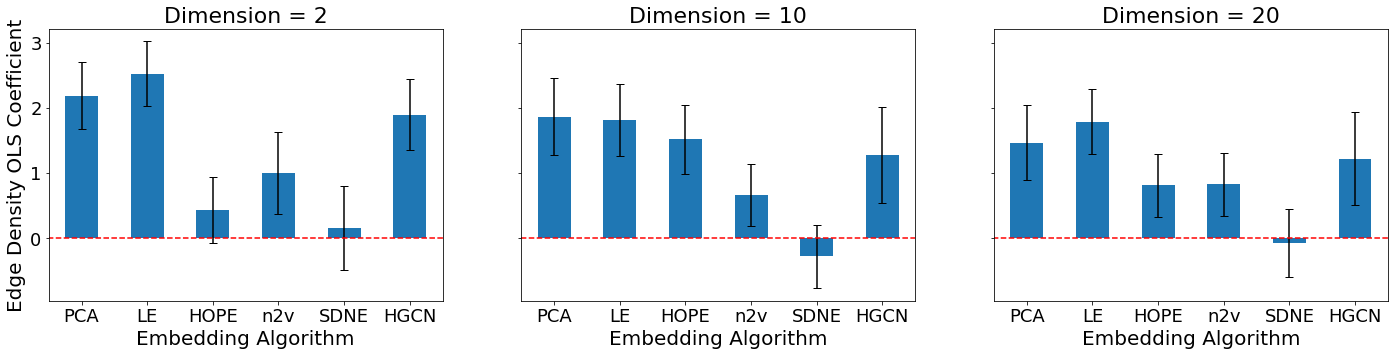

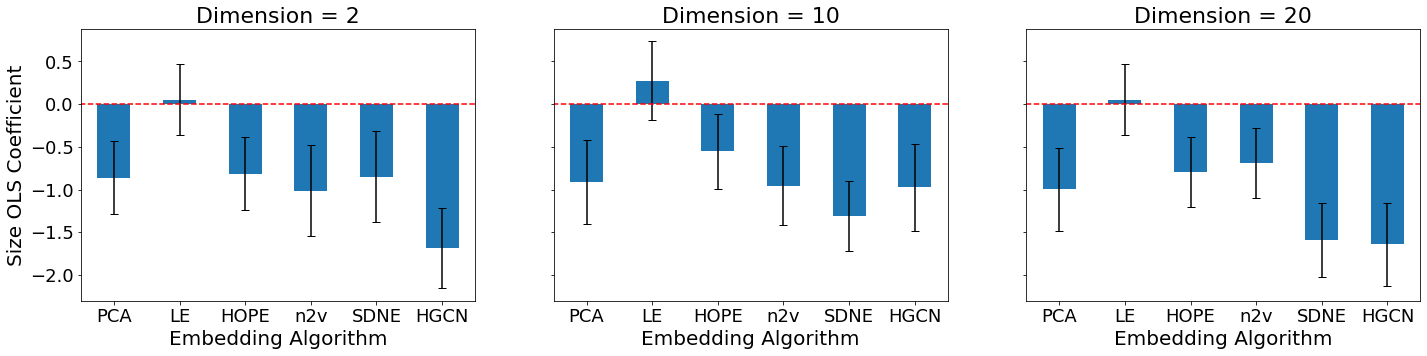

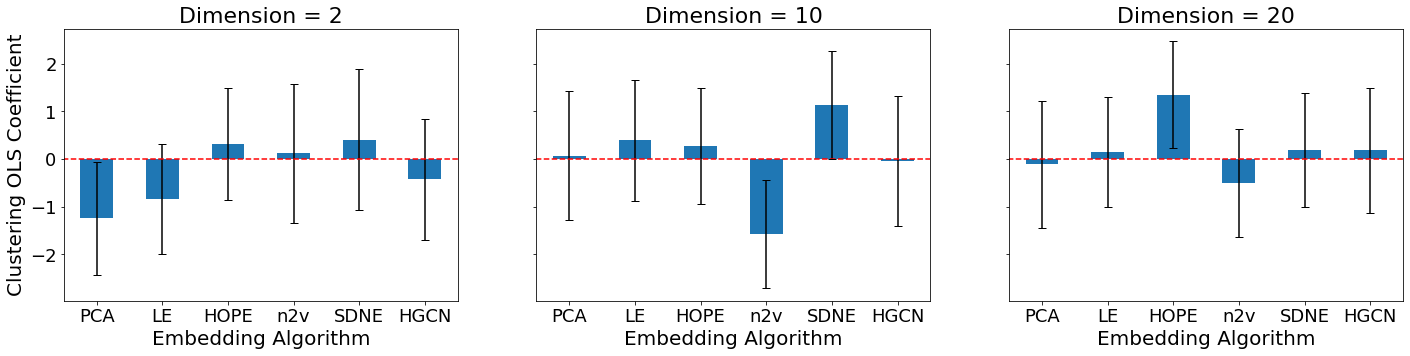

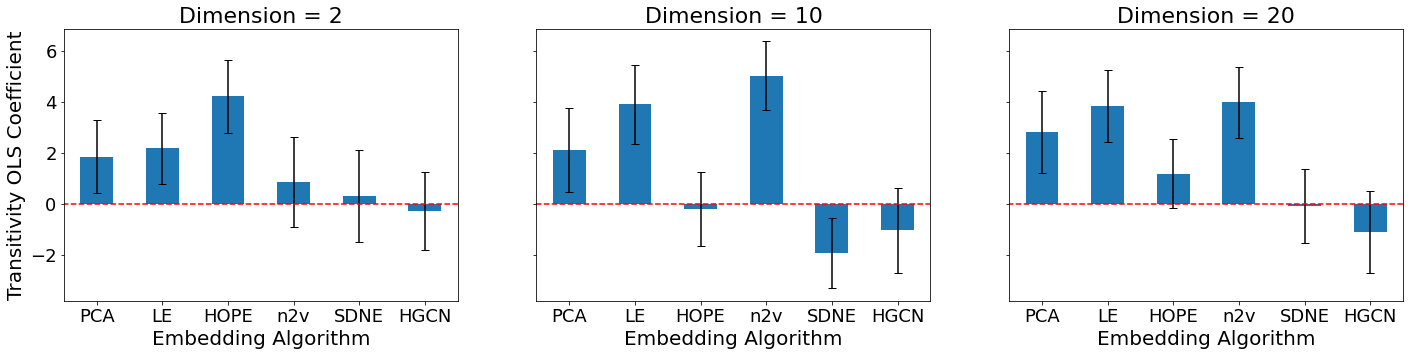

In [14]:
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=22)     # fontsize of the axes title
#plt.rc('axes', titleweight="bold")     # fontweight of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels

feature_title = {
    "EdgeDensity": "Edge Density",
    "Size": "Size",
    "Clustering": "Clustering",
    "Transitivity": "Transitivity"
}
for coef_name in coefs:
    fig, axs = plt.subplots(nrows=1, ncols=len(d_s), figsize=(len(d_s*8), 5), sharey=True)
    for d_idx in range(len(d_s)):
        d = d_s[d_idx]
        reg_results_pd_subset = reg_results_pd[np.all([reg_results_pd["Embedding Dimension"] == d,\
                                              reg_results_pd["Coefficient Name"] == coef_name], axis=0)]
        reg_results_pd_subset.plot.bar(x="Embedding Algorithm", y="Coefficient Value", yerr="Coefficient CI",\
                                       capsize=4,\
                                      ax=axs[d_idx], legend=False)
        axs[d_idx].hlines(y=0, xmin=-1, xmax=6, colors="red", linestyles="dashed")
        axs[d_idx].set_ylabel("{} OLS Coefficient".format(feature_title[coef_name]))
        axs[d_idx].set_title("Dimension = {}".format(d))
        axs[d_idx].tick_params(axis='x', labelrotation=0)
        axs[d_idx].set_xticklabels(["PCA", "LE", "HOPE", "n2v", "SDNE", "HGCN"])


In [8]:
reg_results_pd

NameError: name 'reg_results_pd' is not defined